In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torchvision.utils import make_grid
import torch.nn as nn
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F
from PIL import ImageFile
import cv2 as cv


### Loading dataset

In [2]:
data_dir='./og_img_dataset'

In [3]:
image_size = [64,64]
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
train_ds = ImageFolder(data_dir, transform=T.Compose([
    T.Resize(image_size),
    # T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

In [5]:
img,_ = train_ds[10]
print(img.shape)

torch.Size([3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


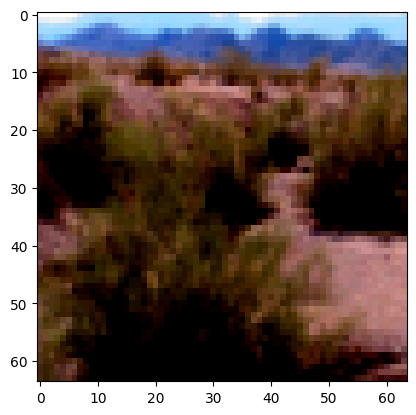

In [6]:
plt.imshow(img.permute(1,2,0))

In [7]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [8]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

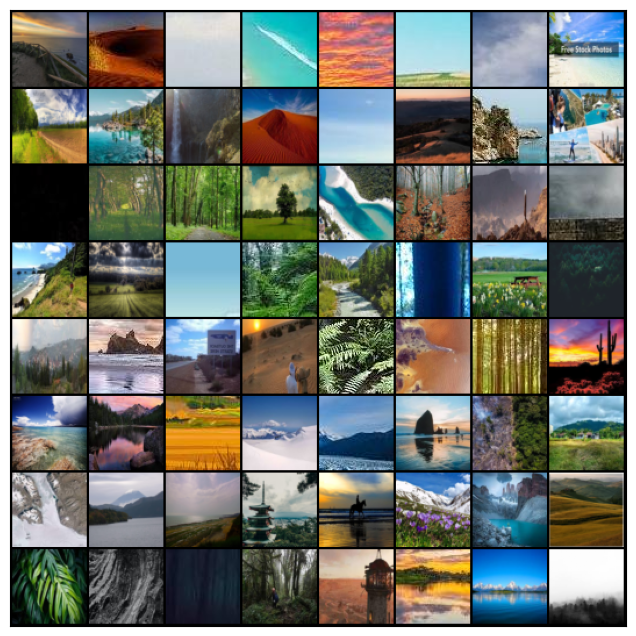

In [10]:
show_batch(train_dl)

### Using GPU

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
train_dl = DeviceDataLoader(train_dl, device)

### Discriminator network

In [14]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [15]:
discriminator = to_device(discriminator, device)

### Generator network

In [16]:
latent_size = 128

In [17]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


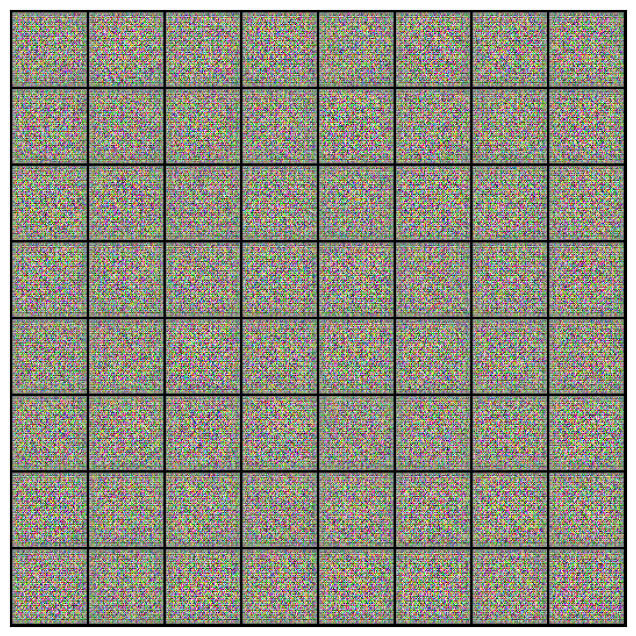

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [19]:
generator = to_device(generator, device)

### Discriminator training

In [20]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

### Generator training

In [21]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


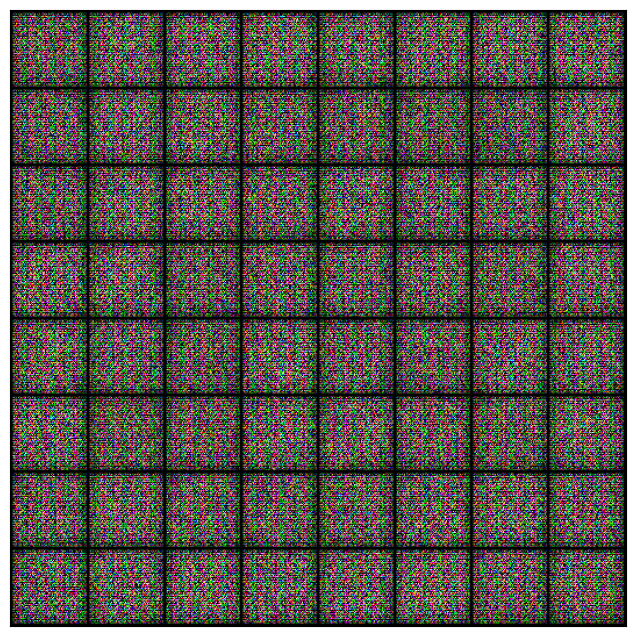

In [25]:
save_samples(0, fixed_latent)

### Full training loop

In [26]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [27]:
lr = 0.0002
epochs = 5

In [ ]:
history = fit(epochs, lr)

### Test

In [77]:
x = torch.randn(16, latent_size, 1, 1, device=device)

In [78]:
y=generator(x)

In [79]:
print(y.shape)

torch.Size([16, 3, 64, 64])


In [80]:
imgs=[]
for i in range(0,16):
    imgs.append(T.functional.to_pil_image(y[i]))

In [81]:
print(imgs)

[<PIL.Image.Image image mode=RGB size=64x64 at 0x2487BB88D30>, <PIL.Image.Image image mode=RGB size=64x64 at 0x24812924760>, <PIL.Image.Image image mode=RGB size=64x64 at 0x24812924AC0>, <PIL.Image.Image image mode=RGB size=64x64 at 0x2481294FAC0>, <PIL.Image.Image image mode=RGB size=64x64 at 0x2487BAF7430>, <PIL.Image.Image image mode=RGB size=64x64 at 0x2487BAF7B50>, <PIL.Image.Image image mode=RGB size=64x64 at 0x2487BAF7AC0>, <PIL.Image.Image image mode=RGB size=64x64 at 0x2480D9D11C0>, <PIL.Image.Image image mode=RGB size=64x64 at 0x2480D9D1A00>, <PIL.Image.Image image mode=RGB size=64x64 at 0x2480D9D1190>, <PIL.Image.Image image mode=RGB size=64x64 at 0x2480D9D1460>, <PIL.Image.Image image mode=RGB size=64x64 at 0x2480D9D1310>, <PIL.Image.Image image mode=RGB size=64x64 at 0x2480D9D1E80>, <PIL.Image.Image image mode=RGB size=64x64 at 0x2480D9D1BB0>, <PIL.Image.Image image mode=RGB size=64x64 at 0x2480D9D1CD0>, <PIL.Image.Image image mode=RGB size=64x64 at 0x2480D9D14F0>]


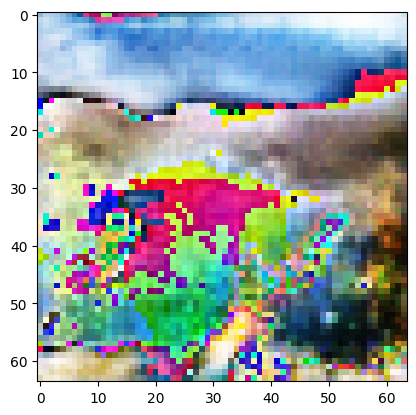

In [82]:
plt.imshow(imgs[0])

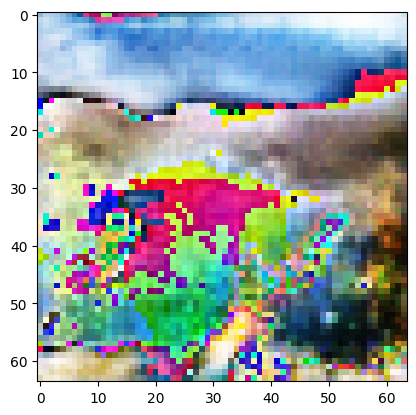

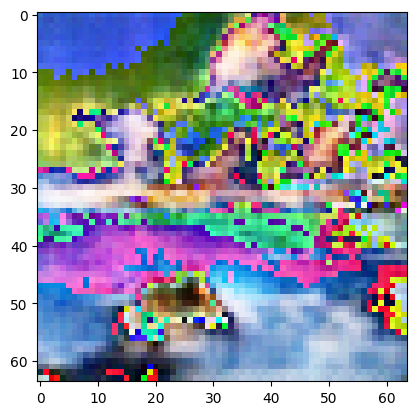

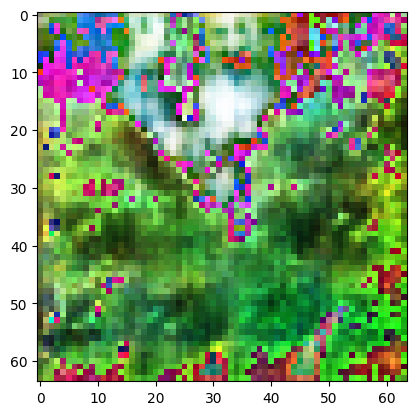

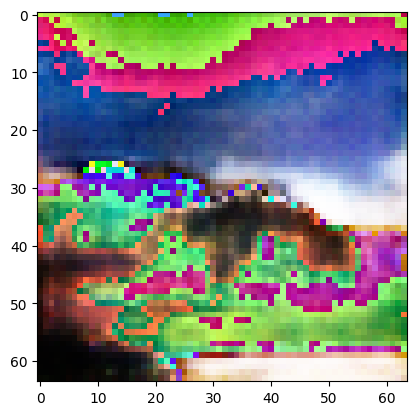

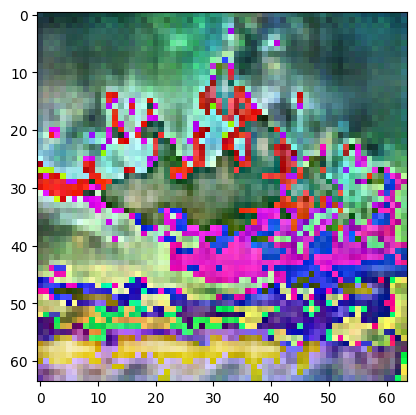

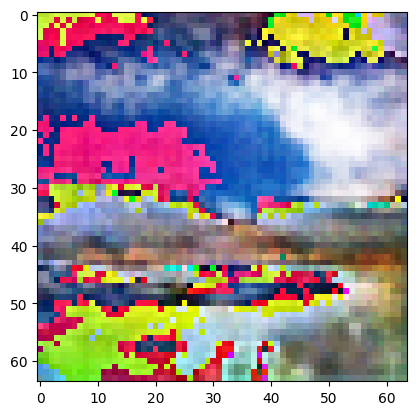

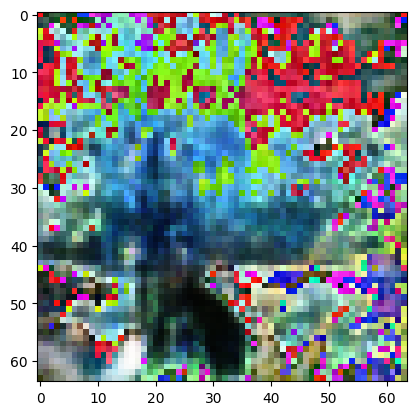

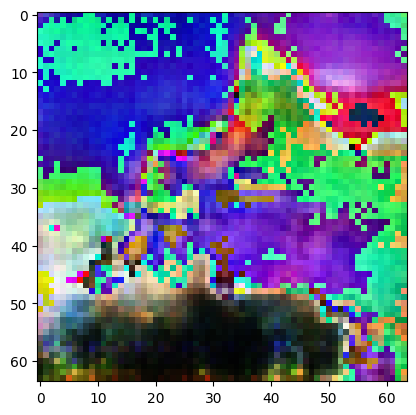

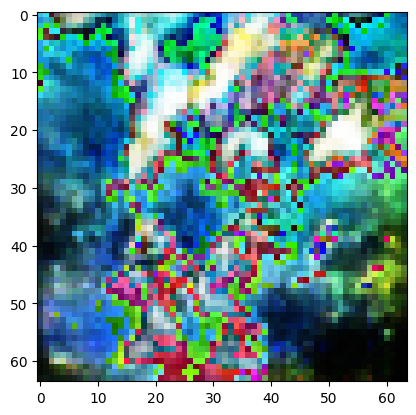

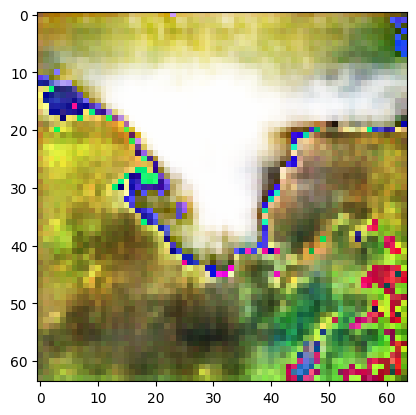

In [83]:
for i in range(10):
    plt.imshow(imgs[i])
    plt.show()
    

### Transfer learning

In [64]:
generator.parameters()

<generator object Module.parameters at 0x000001CED791E4A0>

In [66]:
generator_weights=generator.state_dict()

In [67]:
generator_weights

OrderedDict([('0.weight',
              tensor([[[[ 2.0512e-02, -1.1069e-03,  5.4640e-03,  2.9138e-02],
                        [ 1.1252e-02,  5.1691e-03,  1.7250e-02, -1.2856e-02],
                        [ 1.7947e-02,  8.9459e-04, -2.6961e-04,  5.2553e-03],
                        [-9.9416e-03,  1.0123e-02,  7.6844e-03,  1.6246e-02]],
              
                       [[-4.8569e-03,  3.8411e-04,  4.3527e-03,  9.5806e-03],
                        [ 2.1294e-02,  3.5677e-03,  1.6246e-04,  5.2622e-03],
                        [-9.0461e-03,  5.1920e-03,  1.4497e-03,  1.2608e-02],
                        [-1.0403e-02,  6.0026e-03, -6.2729e-03,  1.4437e-02]],
              
                       [[ 2.9841e-03, -4.9845e-04,  1.4442e-02, -5.3017e-03],
                        [-1.8138e-02,  7.1689e-03,  4.5873e-03,  9.0890e-03],
                        [-1.1347e-02, -7.6787e-03,  1.1466e-02, -2.3300e-03],
                        [ 1.5194e-02,  4.1924e-03,  7.1468e-03, -8.5054e-03]],
     

In [68]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [33]:
new_generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [40]:
pretrained_disc = torch.load('D.pth')
pretrained_gen = torch.load('G.pth')

In [42]:
pretrained_gen

OrderedDict([('0.weight',
              tensor([[[[ 2.0512e-02, -1.1069e-03,  5.4640e-03,  2.9138e-02],
                        [ 1.1252e-02,  5.1691e-03,  1.7250e-02, -1.2856e-02],
                        [ 1.7947e-02,  8.9459e-04, -2.6961e-04,  5.2553e-03],
                        [-9.9416e-03,  1.0123e-02,  7.6844e-03,  1.6246e-02]],
              
                       [[-4.8569e-03,  3.8411e-04,  4.3527e-03,  9.5806e-03],
                        [ 2.1294e-02,  3.5677e-03,  1.6246e-04,  5.2622e-03],
                        [-9.0461e-03,  5.1920e-03,  1.4497e-03,  1.2608e-02],
                        [-1.0403e-02,  6.0026e-03, -6.2729e-03,  1.4437e-02]],
              
                       [[ 2.9841e-03, -4.9845e-04,  1.4442e-02, -5.3017e-03],
                        [-1.8138e-02,  7.1689e-03,  4.5873e-03,  9.0890e-03],
                        [-1.1347e-02, -7.6787e-03,  1.1466e-02, -2.3300e-03],
                        [ 1.5194e-02,  4.1924e-03,  7.1468e-03, -8.5054e-03]],
     

In [43]:
new_generator.load_state_dict(pretrained_gen)

<All keys matched successfully>

In [51]:
new_discriminator=discriminator

In [53]:
new_discriminator.load_state_dict(pretrained_disc)

<All keys matched successfully>

In [44]:
for param in new_generator.parameters():
    param.requires_grad = False

In [54]:
for param in new_discriminator.parameters():
    param.requires_grad = False

In [45]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(new_generator.parameters(), lr=0.001)

In [55]:
new_discriminator = to_device(new_discriminator, device)

In [46]:
new_generator = to_device(new_generator, device)

In [47]:
num_epochs=5

In [48]:
latent_dim=torch.randn(8, latent_size, 1, 1, device=device)

In [50]:
print(device)

cuda


In [ ]:
for epoch in range(num_epochs):
    for real_images, _ in train_dl:
        # Train the discriminator (if needed)
        # ...

        # Train the generator
        optimizer.zero_grad()
        fake_images = new_generator(latent_dim)
        fake_predictions = new_discriminator(fake_images)
        loss = criterion(fake_predictions, torch.ones_like(fake_predictions))
        loss.backward()
        optimizer.step()

In [92]:
y_trans=new_generator(latent_dim)

In [93]:
y_trans.shape

torch.Size([64, 3, 64, 64])

In [95]:
imgs=[]
for i in range(0,64):
    imgs.append(T.functional.to_pil_image(y_trans[i]))

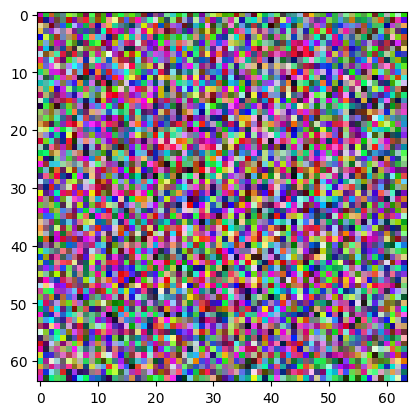

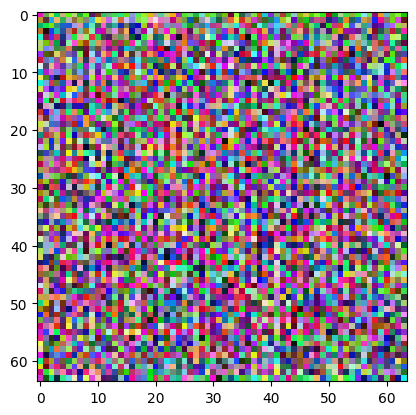

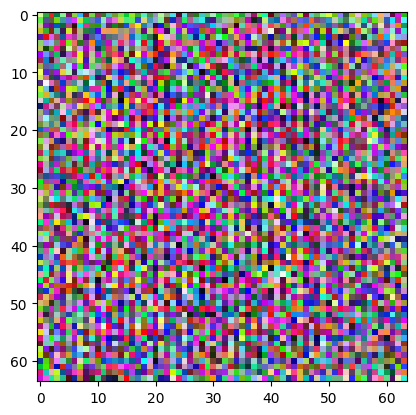

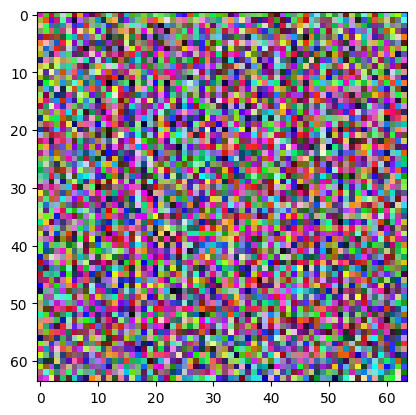

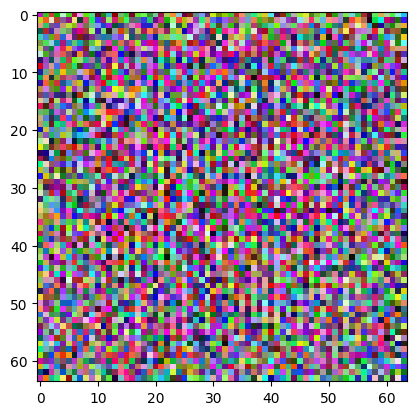

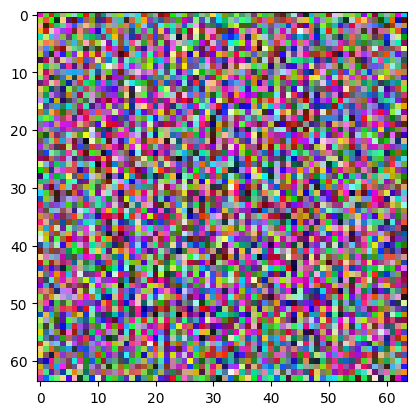

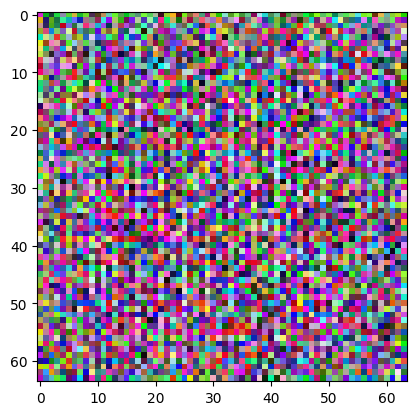

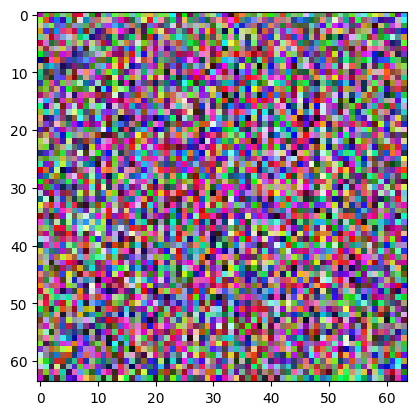

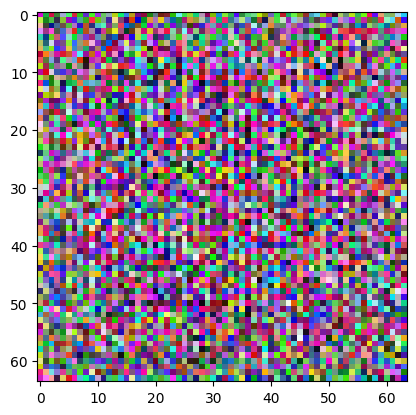

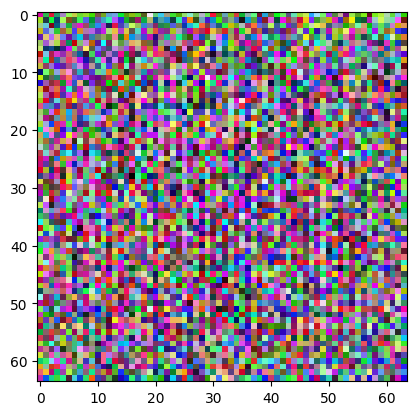

In [96]:
for i in range(10):
    plt.imshow(imgs[i])
    plt.show()